In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from nowcasting_dataset.data_sources.gsp import eso
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 5)

Compute very simple forecast performance metrics for ESO's GSP-level PV forecasts.

The basic outline of this notebook is:

1. Load the "ground truth" estimated total PV generation from each Grid Supply Point from Sheffield Solar and metadata for each GSP.
2. Load ESO's PV forecasts
3. Select just two forecast timesteps: 30-minutes and 1-hour ahead.
4. Throw away nighttime hours (becuase it's easy to forecast PV at night!  So including nighttime hours will produce an overly flattering set of metrics.  And OCF's PV nowcasting code only uses daylight hours.)
5. Structure both the "ground truth" and ESO's forecasts each as a 2-dimensional `pd.DataFrame` with `target_datetime` and the index and `gsp_name` as the columns.
6. Compute the absolute error for each GSP and each timestep.  Normalise by GSP capacity.  Then take the mean per GSP and then the mean across all GSPs.

# Load and prepare data

In [2]:
# The "ground truth" estimated total PV generation from each Grid Supply Point from Sheffield Solar:
GSP_ZARR_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/GSP/v1/pv_gsp.zarr")

# ESO's GSP PV forecasts, converted to NetCDF using scripts/convert-ESO-PV-forecasts-from-CSV-to-HDF5.py
ESO_PV_FORECASTS_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/other_organisations_pv_forecasts/National_Grid_ESO/NetCDF/ESO_GSP_PV_forecasts.nc")

## Load Sheffield Solar PV live & GSP metadata

In [3]:
pv_live_dataset = xr.open_dataset(GSP_ZARR_PATH, engine="zarr")

# Convert 'gsp_id' from strings like '1', '2', etc. to ints
pv_live_dataset['gsp_id'] = pv_live_dataset['gsp_id'].astype(int)

In [4]:
# Use the same name for the datetime dimension as is used in the ESO PV forecasts.
pv_live_dataset = pv_live_dataset.rename({'datetime_gmt': 'target_date_time'})

In [5]:
# The 'generation_mw' is actually the normalised generation.  So mulitply by capacity to get the true generation in MW.
# See https://github.com/openclimatefix/nowcasting_dataset/issues/241
pv_live_dataset['generation_mw'] = pv_live_dataset['generation_mw'] * pv_live_dataset['installedcapacity_mwp']

In [6]:
# Download metadata from ESO for each GSP.  We need this because
# the GSP PV data from Sheffield Solar uses integer gsp_ids, whilst
# the ESO forecasts use textual gsp_names.  So we need the metadata
# to allow us to map from gsp_id to gsp_name.
gsp_metadata = eso.get_gsp_metadata_from_eso(calculate_centroid=False)

In [7]:
# Create a pd.Series which maps from integer GSP ID to textual GSP name.
gsp_id_to_name = (
    gsp_metadata[['gsp_id', 'gsp_name']]
    .dropna()
    .astype({'gsp_id': int})
    .set_index('gsp_id')
    .squeeze()
)

In [8]:
# Set the GSP _name_ as the coordinates for the PV live dataset:
pv_live_dataset = pv_live_dataset.assign_coords(gsp_name=("gsp_id", gsp_id_to_name[pv_live_dataset['gsp_id']]))
pv_live_dataset = pv_live_dataset.swap_dims({'gsp_id': 'gsp_name'})
pv_live_dataset

<xarray.Dataset>
Dimensions:                (target_date_time: 52609, gsp_name: 338)
Coordinates:
  * target_date_time       (target_date_time) datetime64[ns] 2018-01-01 ... 2...
    gsp_id                 (gsp_name) int64 1 2 3 4 5 6 ... 334 335 336 337 338
  * gsp_name               (gsp_name) object 'COWL_1' 'ECLA_1' ... 'FINN'
Data variables:
    generation_mw          (target_date_time, gsp_name) float64 0.0 0.0 ... 0.0
    installedcapacity_mwp  (target_date_time, gsp_name) float64 ...

In [9]:
# Prepare the Sheffield Solar PV capacity per GSP ready for normalising the errors later...
pv_capacity_mw_df = (
    pv_live_dataset['installedcapacity_mwp']
    .to_dataframe()
    .reset_index()
    .pivot_table(
        index='target_date_time', 
        values='installedcapacity_mwp', 
        columns='gsp_name')
)

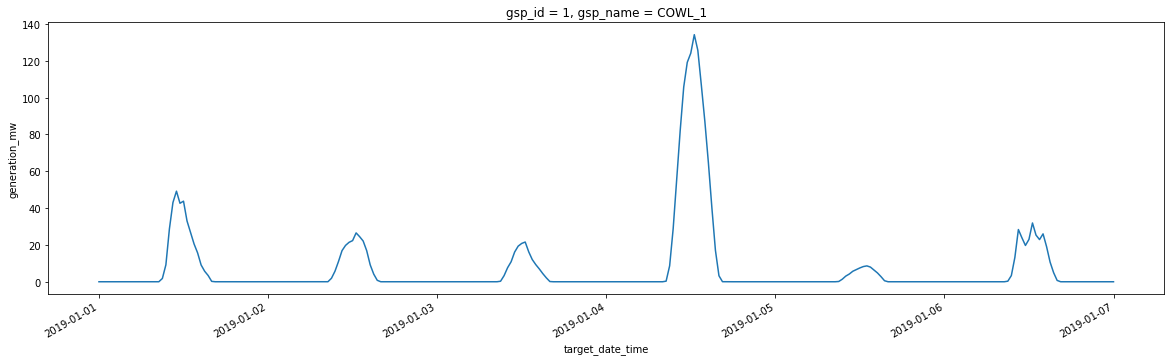

In [10]:
# Sanity check plot
pv_live_dataset.sel(
    gsp_name="COWL_1", 
    target_date_time=slice(
        pd.Timestamp("2019-01-01"), 
        pd.Timestamp("2019-01-07"))
)['generation_mw'].plot();

## Load ESO PV forecasts

In [11]:
eso_pv_forecasts_dataset = xr.open_dataset(ESO_PV_FORECASTS_PATH)
eso_pv_forecasts_dataset = eso_pv_forecasts_dataset.rename({'gsp_id': 'gsp_name'})
eso_pv_forecasts_dataset

<xarray.Dataset>
Dimensions:             (gsp_name: 350, step: 97, forecast_date_time: 9036)
Coordinates:
  * gsp_name            (gsp_name) object 'ABHA1' 'ABNE_P' ... 'WYMOM_1'
  * step                (step) timedelta64[ns] 00:00:00 ... 2 days 00:00:00
  * forecast_date_time  (forecast_date_time) datetime64[ns] 2020-06-01T00:30:...
Data variables:
    ASL                 (gsp_name, forecast_date_time, step) float32 ...
    ML                  (gsp_name, forecast_date_time, step) float32 ...

In [12]:
# Select just two timesteps: 30 minutes and 1 hour ahead:
ESO_FORECAST_ALGO_NAME = 'ML'  # Either ASL or ML.
selected_eso_forecasts_dataarray = (
    eso_pv_forecasts_dataset[ESO_FORECAST_ALGO_NAME]
    .sel(step=slice(pd.Timedelta("30 minutes"), pd.Timedelta("1 hour"))))

selected_eso_forecasts_dataarray

<xarray.DataArray 'ML' (gsp_name: 350, forecast_date_time: 9036, step: 2)>
[6325200 values with dtype=float32]
Coordinates:
  * gsp_name            (gsp_name) object 'ABHA1' 'ABNE_P' ... 'WYMOM_1'
  * step                (step) timedelta64[ns] 00:30:00 01:00:00
  * forecast_date_time  (forecast_date_time) datetime64[ns] 2020-06-01T00:30:...

## Convert to a 2D pd.DataFrame where the index is target_datetime and the columns are GSP names

### Convert ESO PV forecasts to a DataFrame

In [13]:
selected_eso_forecasts_df = selected_eso_forecasts_dataarray.to_dataframe()
selected_eso_forecasts_df = selected_eso_forecasts_df.reset_index()

# Calculate the `target_date_time` (the time that the forecasts are _about_,
# and the time that needs to be aligned with the ground truth):
selected_eso_forecasts_df['target_date_time'] = selected_eso_forecasts_df['forecast_date_time'] + selected_eso_forecasts_df['step']

# Deliberately ignore 'forecast_date_time' and 'step' because we don't need those from here onwards.
selected_eso_forecasts_df = selected_eso_forecasts_df.pivot_table(
    values=ESO_FORECAST_ALGO_NAME,
    columns='gsp_name',
    index='target_date_time'
).sort_index()

selected_eso_forecasts_df

gsp_name,ABHA1,ABNE_P,ABTH_1,ACTL_2,ACTL_C,ALNE_P,ALST_3,ALVE1,AMEM_1,ARBR_P,...,WIOW_P,WISD_1,WISD_6,WISH,WMEL_1,WOHI_P,WTHU31,WWEY_1,WYLF_1,WYMOM_1
target_date_time,,,,,,,,,,,,,,,,,,,,,
2020-06-01 01:00:00,2.62,0.00,0.51,0.0,NaN,0.01,NaN,0.00,0.00,0.03,...,0.00,0.0,NaN,0.00,0.00,0.00,0.0,0.00,0.15,0.24
2020-06-01 01:30:00,1.83,0.01,0.46,0.0,NaN,0.00,NaN,0.95,-0.01,-0.12,...,-0.01,0.0,NaN,0.01,-0.03,0.01,0.0,0.00,0.26,0.10
2020-06-01 02:00:00,0.00,0.00,1.18,0.0,NaN,0.01,NaN,0.00,0.00,0.00,...,0.00,0.0,NaN,0.01,0.31,0.00,0.0,0.00,0.04,0.00
2020-06-01 02:30:00,0.04,0.04,0.71,0.0,NaN,0.00,NaN,0.42,-0.02,0.01,...,0.00,0.0,NaN,0.00,0.15,0.00,0.0,-0.01,0.06,-0.08
2020-06-01 03:00:00,1.82,0.11,1.25,0.0,NaN,0.00,NaN,0.34,0.00,0.15,...,0.00,0.0,NaN,0.00,0.00,0.00,0.0,0.00,0.29,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 22:00:00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00
2021-08-31 22:30:00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00
2021-08-31 23:00:00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00


### Convert PV Live to a DataFrame

In [14]:
pv_live_df = pv_live_dataset["generation_mw"].to_dataframe()
pv_live_df = (
    pv_live_df
    .reset_index()
    .drop(columns='gsp_id')
    .pivot_table(
        index='target_date_time',
        columns='gsp_name',
        values='generation_mw')
    .sort_index()
)

pv_live_df

gsp_name,ABHA1,ABNE_P,ABTH_1,ACTL_2,ALNE_P,ALVE1,AMEM_1,ARBR_P,ARMO_P,AXMI1,...,WIMBS1,WIOW_P,WISD_1,WISH,WMEL_1,WOHI_P,WTHU31,WWEY_1,WYLF_1,WYMOM_1
target_date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plot sanity check

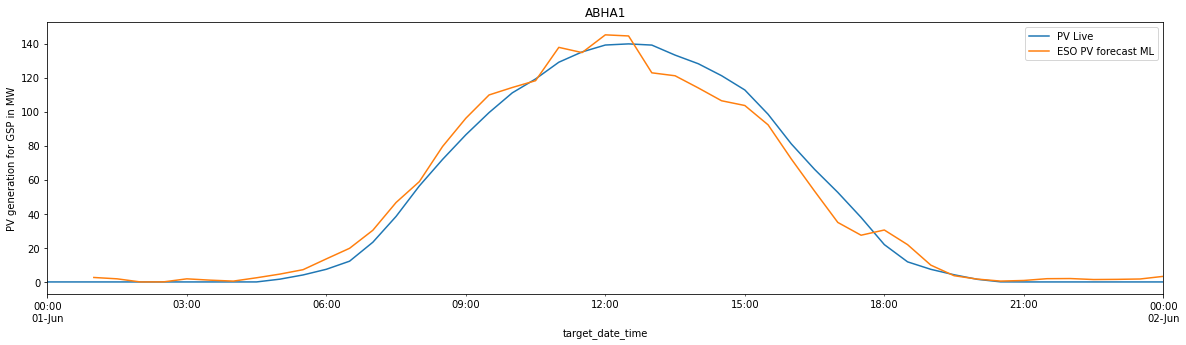

In [15]:
fig, ax = plt.subplots()

gsp_name = 'ABHA1'
datetime_slice = slice(pd.Timestamp("2020-06-01 00:00"), pd.Timestamp("2020-06-02 00:00"))

pv_live_df[gsp_name][datetime_slice].plot(ax=ax, label='PV Live')
selected_eso_forecasts_df[gsp_name][datetime_slice].plot(ax=ax, label=f'ESO PV forecast {ESO_FORECAST_ALGO_NAME}')
ax.legend()
ax.set_ylabel('PV generation for GSP in MW')
ax.set_title(gsp_name);

## Compute forecast errors

In [16]:
error_mw = selected_eso_forecasts_df - pv_live_df

In [17]:
# Quick hack to drop nighttime errors
error_mw = error_mw[(error_mw.index.hour > 8) & (error_mw.index.hour < 18)]

In [18]:
# Normalise the errors by the installed PV capacity per GSP per timestep
normalised_error = error_mw / pv_capacity_mw_df

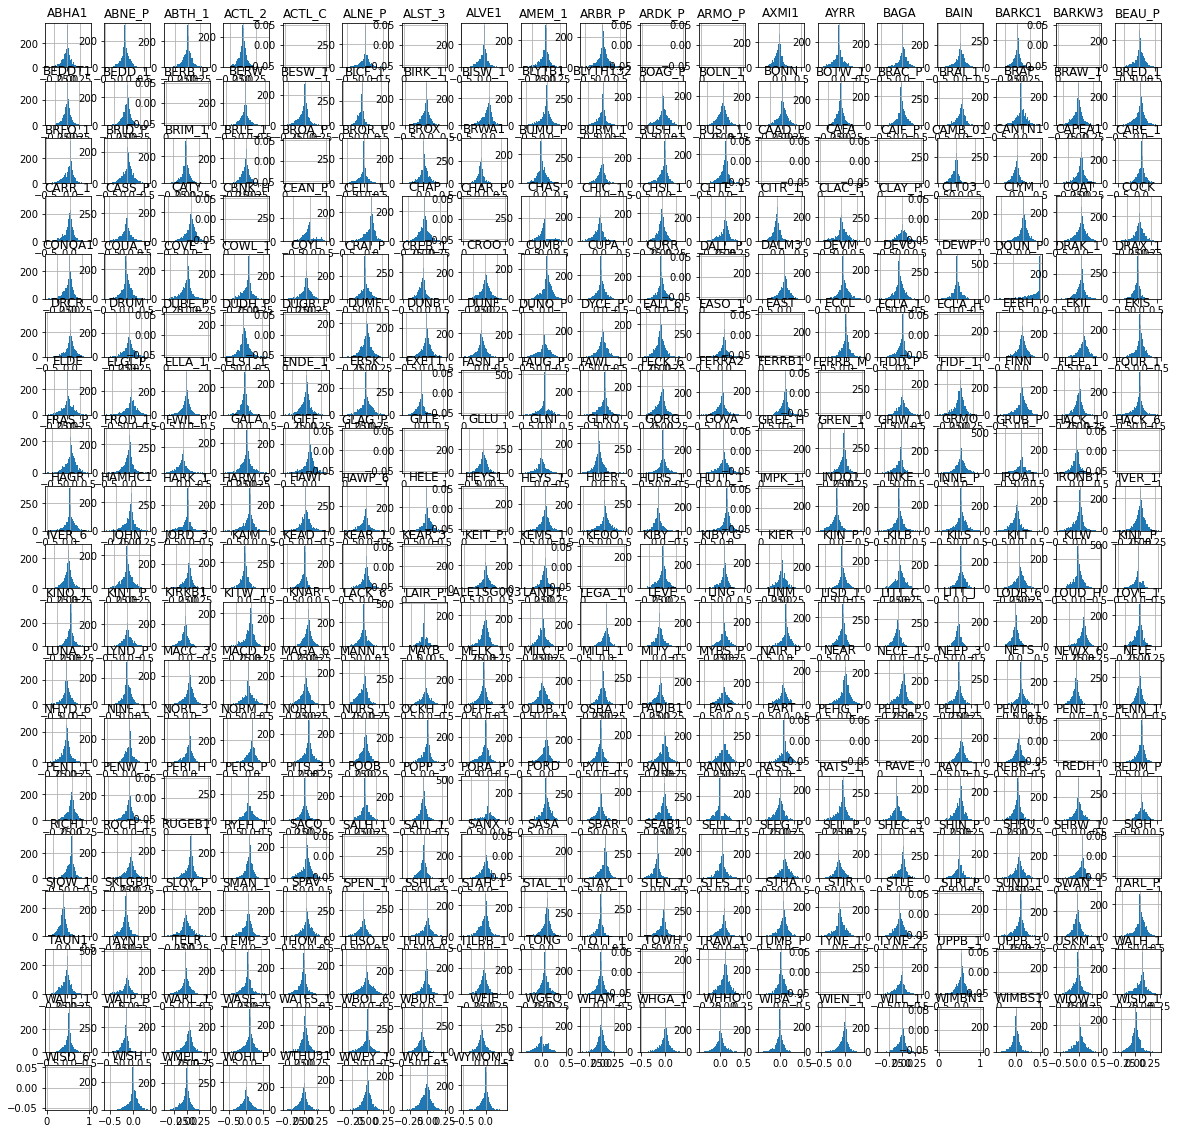

In [19]:
normalised_error.hist(bins=64, figsize=(20, 20));

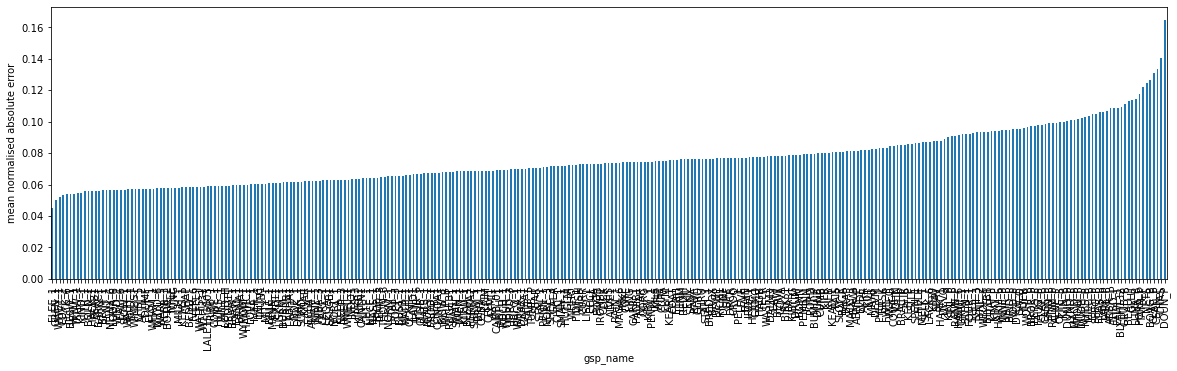

In [20]:
mean_normalised_abs_error = normalised_error.dropna(axis='index', how='all').dropna(axis='columns', how='all').abs().mean()

# Plot
ax = mean_normalised_abs_error.sort_values().plot.bar()
ax.set_ylabel('mean normalised absolute error');

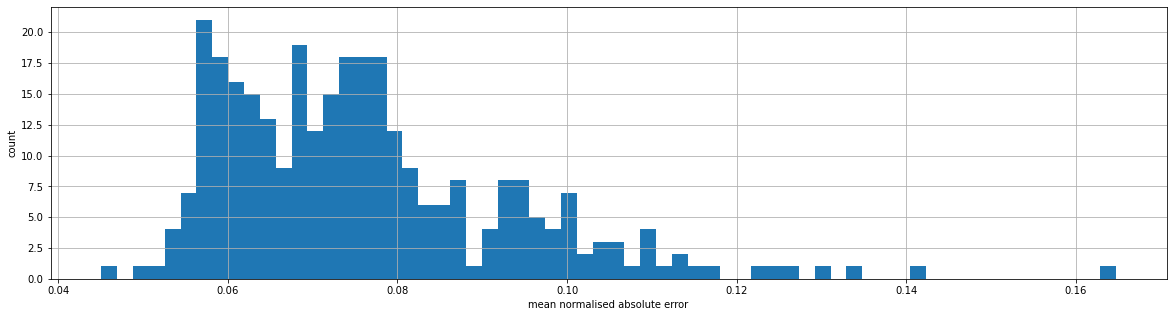

In [21]:
ax = mean_normalised_abs_error.hist(bins=64)
ax.set_ylabel('count')
ax.set_xlabel('mean normalised absolute error');

In [22]:
mean_normalised_abs_error.mean()

0.07611607670409785

Normalised mean absolute errors:

* ASL: 0.069
* ML: 0.076